<a href="https://colab.research.google.com/github/FabriceBeaumont/4216_Biomedical_DS_and_AI/blob/main/Sheet8/Assignment8_Solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, KFold, cross_val_predict
from sklearn.calibration import calibration_curve

In [ ]:
def get_dataset_from_github(filename, index_col_str=None, header_str='infer'):    
    data_file_path = "https://raw.githubusercontent.com/FabriceBeaumont/4216_Biomedical_DS_and_AI/tree/main/Datasets"
    if index_col_str is None and header_str == 'infer':
      data = pd.read_csv(data_file_path + filename)
    elif index_col_str is None:
        data = pd.read_csv(data_file_path + filename, header=header_str)
    elif header_str == 'infer':
      data = pd.read_csv(data_file_path + filename, index_col=index_col_str)
    else:
      data = pd.read_csv(data_file_path + filename, index_col=index_col_str, header=header_str)

    return data

In [ ]:
# titanic_survival_ds = get_dataset_from_github("/titanic_survival_data.csv")
# If this does not work, load the file (temporarily) into the Colab-File system (left side) 
# from your local files. Then execute as usual:
titanic_survival_ds = pd.read_csv("titanic_survival_data.csv")

titanic_survival_ds.head(4)

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,no_cabin,Label
0,1,3,0,22.0,1,0,7.2500,0,2,0
1,2,1,1,38.0,1,0,71.2833,1,1,1
2,3,3,1,26.0,0,0,7.9250,0,2,1
3,4,1,1,35.0,1,0,53.1000,0,1,1


## Biomedical Data Science & AI

## Assignment 8

#### Group members:  Fabrice Beaumont, Fatemeh Salehi, Genivika Mann, Helia Salimi, Jonah

---
### Exercise 1 - Ensemble Learning


#### 1.1. Inform yourself about **gradient boosting**, then answer the following questions in your own words:

In-depth resource for Gradient Boosting: https://explained.ai/gradient-boosting/index.html

Gradient Boosting is a machine learning technique which uses Gradient Descent and Boosting. It aims at fitting an additive model by introducing **weak learners** (i.e Decision trees) such that the recently added weak learner compensates the shortcomings of existing weak learners. The shortcoming of existing weak learners are identified by gradients in the loss function. Any user specified loss function can be optimised by a gradient boosting algorithm. The objective is to minimise the loss function by adding weak learners using Gradient Descent.

a. What do the individual **weak learners** model? How does this relate to the
gradient of the loss function?


- The weak learners are trained with the objective of minimising the loss function, hence they are trained on the residuals of the model. Each new weak learner will be fitted on the **residual error** usually known as **pseudo-residual** produced by the existing sequence of learners.

- The gradient boosting algorithm performs **gradient descent minimisation on some loss function** between the true and the predicted values. We perform gradient descent to bring the predicted values closer to the true value by minimising the residual. The residual is a vector which not only provides the magnitude of difference between the true and the predicted value but also the direction of better approximation (w.r.t. minimization of loss function). Hence we are chasing the (negative) gradient of the loss function via gradient descent by chasing the direction of residual. Thus we perform gradient descent on the loss function.

- The gradient boosted model that trains weak learners on residual vectors optimises the mean squared error (MSE; $L_2$ loss), ...

- ...while the model that trains the weak learners on the sign vector (only direction of residual without the magnitude) optimises the mean absolute error(MAE; $L_1$ loss).

b. What is the difference between **gradient boosting** and **random forest**?

- Gradient Boosting (GB) is a forward stage-wise additive model, that builds and adds one tree at a time with the objective of minimising the loss function (computed by considering the existing sequence of trees). Random forest (RF) on the other hand builds all trees independently - using random samples of the data (to prevent overfitting).


- GB focusses step by step on difficult examples - making it suitable for datasets with class imbalance. No such quality is present in RF. Additionally, any user specified loss function can be optimised by a gradient boosting algorithm.


- RF combines the results of all the trees at the end after the construction of all trees. GB on the other hand, takes the predictions of the sequence of trees into consideration at each stage of the algorithm.


- If the parameters are tuned carefully, GB can perform better than RF. However it is difficult to tune GB since there are much more parameters that need to be tuned.


- GB is more sensitive to overfitting if the data is noisy. RF is more robust and should be considered in this case.


- Training GB generally takes longer then RF, since the trees are constructed sequentially.

#### 1.2. Which modifications make gradient boosting **robust against overfitting**?

Gredient Boosting is not robust against overfitting the training data as it is a greedy algorithm. This problem can be resolved by using regualarization methods which penalize different aspects of the algorithm. The following methods can be used:
- **Tree constraints:** The idea is that is the trees are more constrained, more trees need to be constructed. The constraints can be imposed on 
    - the number of trees (~"keep on adding trees until no improvement is observed"), 
    - tree depth (~"shorter trees are preferred as deeper trees are considered more complex"),
    - number of nodes/leaves of tree and
    - number of observations per split and minimum improvement to loss.

- **Weighted Updates:** The prediction of each tree is weighed by a learning rate or shrinkage to slow down the learning by the algorithm. Shrinkage reduces the influence of each individual tree and leaves space for future trees to improve the model.


- **Stochastic Gradient Boosting:** The method aims at reducing the correlation of the trees in the sequence of trees. This is achieved by using only a subsample of the training data to fit the  base learner.


- **Penalized Gradient Boosting:** Regression trees (a variant of decision trees which contain only numeric values at leaf nodes) can be used in GB. The leaf values act as weights and can be regularised using $L_1$ or $L_2$ regularization to prevent overfitting.

#### 1.3. Using the `titanic_survival_dataset.csv`, train the following models using nested cross validation while optimizing a selected number of hyperparameters in the inner loop using grid search, then compute the probabilities of your targets:

In [ ]:
# Load the dataset
titanic_data = pd.read_csv('titanic_survival_data.csv', index_col="PassengerId")
titanic_data.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,no_cabin,Label
PassengerId,,,,,,,,,
1,3,0,22.0,1,0,7.2500,0,2,0
2,1,1,38.0,1,0,71.2833,1,1,1
3,3,1,26.0,0,0,7.9250,0,2,1
4,1,1,35.0,1,0,53.1000,0,1,1
5,3,0,35.0,0,0,8.0500,0,2,0


In [ ]:
# Sepearate features and target (which is stored in column 'Label')
y = titanic_data['Label'].ravel()
X = titanic_data.drop(columns = ['Label'])

#### 1.3.a) Random forest, optimizing the number of estimators

In [ ]:
# Initialize the RF classifier and a parameter grid for the grid search
Random_Forest = RandomForestClassifier()
p_grid_random_forest = {'n_estimators': [100, 150, 200, 300, 400]}

In [ ]:
# Inner Fold - to obtain the best hyperparameters
Random_Forest_Fit = GridSearchCV(
    estimator = Random_Forest,
    param_grid = p_grid_random_forest,
    cv = KFold(shuffle = True),
    verbose = 1
)

Random_Forest_Fit.fit(X, y)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   10.1s finished


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_sc

In [ ]:
# Outer Fold - to perform cross validation based on metrics and compute the probabilities of the target
random_forest_prediction_prob = cross_val_predict(
    estimator = Random_Forest_Fit,
    X = X,
    y = y,
    cv = KFold(shuffle = True),
    method = 'predict_proba', # To obtain prediction probabilities in result
    verbose = 1
)
random_forest_prediction_prob

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    9.6s finished


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    9.5s finished


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    9.4s finished


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    9.5s finished


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    9.5s finished
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   50.1s finished


array([[0.706  , 0.294  ],
       [0.01   , 0.99   ],
       [0.615  , 0.385  ],
       ...,
       [0.605  , 0.395  ],
       [0.155  , 0.845  ],
       [0.98375, 0.01625]])

#### 1.3.b) Gradient boosting, optimizing boosting steps

In [ ]:
# Initialize the GB classifier and a parameter grid for the grid search
GB = GradientBoostingClassifier()
p_grid_gb = {'n_estimators': [10, 50, 100, 200, 300]}

# Inner Fold - to obtain the best hyperparameters
GB_Best_Clf = GridSearchCV(
    estimator = GB,
    param_grid = p_grid_gb,
    cv = KFold(shuffle = True),
    verbose = 1
)

GB_Best_Clf.fit(X, y)

# Outer Fold - to perform cross validation based on metrics and compute the probabilities of the target
gb_prediction_prob = cross_val_predict(
    estimator = GB_Best_Clf,
    X = X,
    y = y,
    cv = KFold(shuffle = True),
    method = 'predict_proba', # To obtain prediction probabilities in result
    verbose = 1
)
gb_prediction_prob

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    3.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    3.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    3.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    3.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    3.1s finished


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    3.1s finished
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   16.0s finished


array([[0.78829091, 0.21170909],
       [0.05449812, 0.94550188],
       [0.49750538, 0.50249462],
       ...,
       [0.54399186, 0.45600814],
       [0.10972886, 0.89027114],
       [0.9760037 , 0.0239963 ]])

#### 1.3.c) Lasso penalized logistic regression, optimizing $L_1$ regularization strength

In [ ]:
# Initialize the Logistic Regression classifier and a parameter grid for the grid search
LR = LogisticRegression(penalty = 'l1', solver = 'liblinear')
p_grid_lr = {'C': [1000, 100, 10, 1, 0.1]}

# Inner Fold - to obtain the best hyperparameters
LR_Best_Clf = GridSearchCV(
    estimator = LR,
    param_grid = p_grid_lr,
    cv = KFold(shuffle = True),
    verbose = 1
)

LR_Best_Clf.fit(X, y)

# Outer Fold - to perform cross validation based on metrics and compute the probabilities of the target
lr_prediction_prob = cross_val_predict(
    estimator = LR_Best_Clf,
    X = X,
    y = y,
    cv = KFold(shuffle = True),
    method = 'predict_proba', # To obtain prediction probabilities in result
    verbose = 1
)
lr_prediction_prob

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished


array([[0.92331682, 0.07668318],
       [0.07173476, 0.92826524],
       [0.41955762, 0.58044238],
       ...,
       [0.44867269, 0.55132731],
       [0.32413817, 0.67586183],
       [0.87865206, 0.12134794]])

In [ ]:
# Converting computed prediction probabilities to dataframes
lr_prob_result = pd.DataFrame(lr_prediction_prob, columns = ['0', '1'])
gb_prob_result = pd.DataFrame(gb_prediction_prob, columns = ['0', '1'])
rf_prob_result = pd.DataFrame(random_forest_prediction_prob, columns = ['0', '1'])

(Using a large parameter grid results in an extended computation time. We advise using a maximum of *five* values per hyperparameter)

#### 1.4. Inform yourself about **calibration curves** (reliability diagrams). Use the predicted probabilities of each model from 3) to plot a calibration curve, then explain your results.

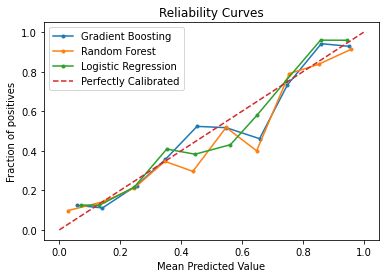

In [ ]:
# Compute fraction of positives and the mean predicted value for plotting
fraction_of_positives_rf, mean_predicted_value_rf = calibration_curve(y, rf_prob_result['1'], n_bins = 10)
fraction_of_positives_lr, mean_predicted_value_lr = calibration_curve(y, lr_prob_result['1'], n_bins = 10)
fraction_of_positives_gb, mean_predicted_value_gb = calibration_curve(y, gb_prob_result['1'], n_bins = 10)

plt.plot(mean_predicted_value_gb, fraction_of_positives_gb, marker = '.', label = 'Gradient Boosting')
plt.plot(mean_predicted_value_rf, fraction_of_positives_rf, marker = '.', label = 'Random Forest')
plt.plot(mean_predicted_value_lr, fraction_of_positives_lr, marker = '.', label = 'Logistic Regression')
plt.plot([0,1], [0,1], linestyle = '--',label = 'Perfectly Calibrated')

plt.xlabel('Mean Predicted Value')
plt.ylabel('Fraction of positives')
plt.title('Reliability Curves')
plt.legend()
plt.show()

Calibration diagrams show how the predicted probabilities of the model are well calibrated  with respect to the true distribution of the class in data. The closer the plot is to the main diagonal, the better calibrated are the probabilities of the model. If the curve is below the main diagonal, the model has *overforcast* (the probabilities are too large). On the other hand, if the curve is above the main diagonal, the model has *underforcast* (the probabilities are too small).


**Inference from Calibration Curves:** 
The GB model and the Logistic Regression are the most calibrated. In the plot, their predicted probabilities almost overlap with the main diagonal for some mean predicted values. 
RF overforcasts and underforcasts the most between the mean predicted value of $0.6$ and $0.8$. None of the models show very poor performance. This can be because we performed nested cross validation before reporting the results. All the plots are close to the perfect calibration line.

---
### Exercise 2 - Machine Learning

#### 2.1. Suppose there is a Multi-Layer Perceptron (MLP) composed of one input layer with *eight* neurons, followed by one hidden layer with *30* artificial neurons, and one output layer with *three* artificial neurons. All artificial neurons use the ReLU activation function.

##### 2.1.a) Deduce the shape of input matrix $X$, hidden layer’s weight vector $W_h$, bias vector $b_h$ and the shape of the network’s output matrix $Y$.

If we suppose each $x_i$ has n features then: $X.shape = (n, 8)$ and $W_h.shape = (30,8)$ <br>
So the shape of the term $XW_h^T$ will be $(n, 30)$ and it should be the same for $b_h^T \Longrightarrow b_h.shape = (30, n)$<br>
$H$ have the shape $(n, 30)$ and $W_o.shape = (3, 30)$ so the shape of the term $HW_o^T$ will be $(n, 3)$ and it should be the same for $b_o^T \Longrightarrow b_o.shape = (3, n) \Longrightarrow Y.shape = (n,3)$<br>


##### 2.1.b) Write the equation that computes the network’s output matrix $Y$ as a function of $X$, $W_h$, $b_h$, $W_o$ and $b_o$.

activation function: $ReLU(X) =$ [ $max(0,x_i)$ for $x_i$ in $X$ ] <br>
$H = XW_h^T + b_h^T$ <br> $out_H = ReLU(H)$ <br>
$Y = out_HW_o^T + b_o^T$ <br> $out_Y = ReLU(Y)$ <br>
$\Longrightarrow out_Y = ReLU((ReLU(XW_h^T + b_h^T)) W_o^T + b_o^T)$

#### 2.2. What are principle and unavoidable limitations of the backpropagation (BP)?

- **Local Minima Problem:** If local minima are present along with global minima in the synaptic weight space, BP algorithm will get trapped in the local minima. Since in this situation, every small change in synaptic weights will increase the cost function.


- **Slow Convergence:** The BP algorithm uses an instantaneous estimate for the gradient of the error-surface in weight space. Due to this stochastic nature of the algorithm, it tends to converge slowly. If the error surface along a weight dimension is flat, the gradient will be small resulting in small updates to the weights. Hence the algorithm will have to undergo a large no. of iterations. In the opposite scenario, if the error surface is curved, the magnitude of gradient will be large causing larger weigth updates and the algorithm might overshoot the minimum of the error surface.


- **Scaling:** It does not scale well to large problems.

#### 2.3. The shown figure is a *three* layer neural network

##### 2.3.a) Compute $h_1$, $h_2$, $o_1$, and the total error using ReLU units. 

*Note*: $b_1$, $b_2$ and $b_3$ represent the biases added to their respective units.

$h_1 = i_1 \times w_1 + i_2 \times w_2 + b_1 = 0.5 \times 0.15 + 0.8 \times 0.2 + 0.4  = 0.635$<br>
$out_{h_1} = ReLU(h_1) = max(0.635, 0) = 0.635$ <br>
$h_2 = i_1 \times w_3 + i_2 \times w_4 + b_2 = 0.5 \times 0.25 + 0.8 \times 0.3 + 0.3 = 0.665$<br>
$out_{h_2} = ReLU(h_2) = max(0.665, 0) = 0.665$ <br>
$o_1 = out_{h_1} \times w_5 + out_{h_2} \times w_6 + b_3 = 0.635 \times 0.4 + 0.665 \times 0.55 + 0.6 = 1.21975$
$out_{o_1} = ReLU(o_1) = max(1.21975, 0) = 1.21975$ <br>
$Error_{total} = Error_1 = \frac{1}{2}(1 - 1.21975)^2 = 0.024145031249999976$

##### 2.3.b) Calculate the updates of the network weights $w_1, \dots , w_6$ and bias terms $b_1$, $b_2$, $b_3$ using backpropagation. Assume a learning rate of $1$ for the sake of simplicity. 

*Note*: Remember that a bias term is equivalent to a weighted constant input 1.

Learning rate: $\gamma = 1$<br><br>
$Error_{total} = \frac{1}{2}(T_1 - out_{o_1})^2$ <br><br>
$ReLU(x) = \begin{cases} x & \text{if } x \geq 0\\ 0 & \text{if }x \lt 0\end{cases}$ <br>
$\lim_{h \to 0^+} \dfrac{f(h) - f(0)}{h} = \lim_{h\to 0^+} \dfrac{h}{h} = 1$<br>
$\lim_{h \to 0^-} \dfrac{f(h) - f(0)}{h} = 0$<br>
$ReLU^{\prime}(x) = \begin{cases} 1 & \text{if } x \geq 0\\ 0 & \text{if }x \lt 0\end{cases}$<br><br><br>

**Error at** $\pmb{w_6}$: $\frac{\partial E_{total}}{\partial w_6} = 
\frac{\partial E_{total}}{\partial out_{o_1}} \times 
\frac{\partial out_{o_1}}{\partial o_1} \times 
\frac{\partial o_1}{\partial w_6} $


$\frac{\partial E_{total}}{\partial out_{o_1}} = 2 \times \frac{1}{2}(T_1 - out_{o_1}) (-1) = -T_1 + out_{o_1} = -1+1.21975 = 0.21975$



$\frac{\partial out_{o_1}}{\partial o_1} = 1$

$\frac{\partial o_1}{\partial w_6} = 1 \times out_{h_2} = 0.665$

$\Longrightarrow \frac{\partial E_{total}}{\partial w_6} = 0.21975 \times 1 \times 0.665 = 0.14613375$<br>
**updating** $\pmb{w_6}: w_6 = w_6-\gamma \times \frac{\partial E_{total}}{\partial w_6} = 0.55 - 1 \times 0.14613375 = 0.40386625$<br><br>

**Error at** $\pmb{w_5}$: $\frac{\partial E_{total}}{\partial w_5} = 
\frac{\partial E_{total}}{\partial out_{o_1}} \times 
\frac{\partial out_{o_1}}{\partial o_1} \times 
\frac{\partial o_1}{\partial w_5} $<br>

$\frac{\partial E_{total}}{\partial out_{o_1}} = 0.21975$<br>
$\frac{\partial out_{o_1}}{\partial o_1} = 1$<br>
$\frac{\partial o_1}{\partial w_5} = 1 \times out_{h_1} = 0.635$

$\Longrightarrow \frac{\partial E_{total}}{\partial w_5} = 0.21975 \times 1 \times 0.635 = 0.13954125$<br>
**updating** $\pmb{w_5}: w_5 = w_5-\gamma \times \frac{\partial E_{total}}{\partial w_5} = 0.4 - 1 \times 0.13954125 = 0.26045875$<br><br>

**Error at** $\pmb{w_4}$: $\frac{\partial E_{total}}{\partial w_4} = 
\frac{\partial E_{total}}{\partial out_{o_1}} \times \frac{\partial out_{o_1}}{\partial o_1} \times 
\frac{\partial o_1}{\partial out_{h_2}} \times 
\frac{\partial out_{h_2}}{\partial h_2} \times 
\frac{\partial h_2}{\partial w_4} $

$\frac{\partial E_{total}}{\partial out_{o_1}} = 0.21975$<br>
$\frac{\partial out_{o_1}}{\partial o_1} = 1$<br>
$\frac{\partial o_1}{\partial out_{h_2}} = 1 \times w_6 = 0.55$<br>
$\frac{\partial out_{h_2}}{\partial h_2} = 1$<br>
$\frac{\partial h_2}{\partial w_4} = 1 \times i_2 = 0.8$

$\Longrightarrow \frac{\partial E_{total}}{\partial w_4} = 0.21975 \times 1 \times 0.55 \times 1 \times 0.8 = 0.09669$<br>
**updating** $\pmb{w_4}: w_4 = w_4-\gamma \times \frac{\partial E_{total}}{\partial w_4} = 0.3 - 1 \times 0.09669 = 0.20331$<br><br>

**Error at** $\pmb{w_3}$: $\frac{\partial E_{total}}{\partial w_3} = 
\frac{\partial E_{total}}{\partial out_{o_1}} \times \frac{\partial out_{o_1}}{\partial o_1} \times 
\frac{\partial o_1}{\partial out_{h_2}} \times 
\frac{\partial out_{h_2}}{\partial h_2} \times 
\frac{\partial h_2}{\partial w_3} $

$\frac{\partial E_{total}}{\partial out_{o_1}} = 0.21975$<br>
$\frac{\partial out_{o_1}}{\partial o_1} = 1$<br>
$\frac{\partial o_1}{\partial out_{h_2}} = 0.55$<br>
$\frac{\partial out_{h_2}}{\partial h_2} = 1$<br>
$\frac{\partial h_2}{\partial w_3} = 1 \times i_1 = 0.5$

$\Longrightarrow \frac{\partial E_{total}}{\partial w_4} = 0.21975 \times 1 \times 0.55 \times 1 \times 0.5 = 0.06043125$<br>
**updating** $\pmb{w_3}: w_3 = w_3-\gamma \times \frac{\partial E_{total}}{\partial w_3} = 0.25 - 1 \times 0.06043125 = 0.18956875$<br><br>

**Error at** $\pmb{w_2}$: $\frac{\partial E_{total}}{\partial w_2} = 
\frac{\partial E_{total}}{\partial out_{o_1}} \times \frac{\partial out_{o_1}}{\partial o_1} \times 
\frac{\partial o_1}{\partial out_{h_1}} \times 
\frac{\partial out_{h_1}}{\partial h_1} \times 
\frac{\partial h_1}{\partial w_2} $

$\frac{\partial E_{total}}{\partial out_{o_1}} = 0.21975$<br>
$\frac{\partial out_{o_1}}{\partial o_1} = 1$<br>
$\frac{\partial o_1}{\partial out_{h_1}} = 1 \times w_5 = 0.4$<br>
$\frac{\partial out_{h_1}}{\partial h_1} = 1$<br>
$\frac{\partial h_1}{\partial w_2} = 1 \times i_2 = 0.8$

$\Longrightarrow \frac{\partial E_{total}}{\partial w_2} = 0.21975 \times 1 \times 0.4 \times 1 \times 0.8 = 0.07032$<br>
**updating** $\pmb{w_2}: w_2 = w_2-\gamma \times \frac{\partial E_{total}}{\partial w_2} = 0.2 - 1 \times 0.07032 = 0.12968$<br><br>

**Error at** $\pmb{w_1}$: $\frac{\partial E_{total}}{\partial w_1} = 
\frac{\partial E_{total}}{\partial out_{o_1}} \times \frac{\partial out_{o_1}}{\partial o_1} \times 
\frac{\partial o_1}{\partial out_{h_1}} \times 
\frac{\partial out_{h_1}}{\partial h_1} \times 
\frac{\partial h_1}{\partial w_1} $

$\frac{\partial E_{total}}{\partial out_{o_1}} = 0.21975$<br>
$\frac{\partial out_{o_1}}{\partial o_1} = 1$<br>
$\frac{\partial o_1}{\partial out_{h_1}} = 1 \times w_5 = 0.4$<br>
$\frac{\partial out_{h_1}}{\partial h_1} = 1$<br>
$\frac{\partial h_1}{\partial w_1} = 1 \times i_1 = 0.5$

$\Longrightarrow \frac{\partial E_{total}}{\partial w_1} = 0.21975 \times 1 \times 0.4 \times 1 \times 0.5 = 0.04395$<br>
**updating** $\pmb{w_1}: w_1 = w_1-\gamma \times \frac{\partial E_{total}}{\partial w_1} = 0.15 - 1 \times 0.04395 = 0.10605$<br><br>

**Error at** $\pmb{b_3}$: $\frac{\partial E_{total}}{\partial b_3} = 
\frac{\partial E_{total}}{\partial out_{o_1}} \times 
\frac{\partial out_{o_1}}{\partial o_1} \times 
\frac{\partial o_1}{\partial b_3} $<br>

$\frac{\partial E_{total}}{\partial out_{o_1}} = 0.21975$<br>
$\frac{\partial out_{o_1}}{\partial o_1} = 1$<br>
$\frac{\partial o_1}{\partial b_3} = 1$

$\Longrightarrow \frac{\partial E_{total}}{\partial b_3} = 0.21975 \times 1 \times 1 = 0.21975$<br>
**updating** $\pmb{b_3}: b_3 = b_3-\gamma \times \frac{\partial E_{total}}{\partial b_3} = 0.6 - 1 \times 0.21975 = 0.38025$<br><br>

**Error at** $\pmb{b_2}$: $\frac{\partial E_{total}}{\partial b_2} = 
\frac{\partial E_{total}}{\partial out_{o_1}} \times \frac{\partial out_{o_1}}{\partial o_1} \times 
\frac{\partial o_1}{\partial out_{h_2}} \times 
\frac{\partial out_{h_2}}{\partial h_2} \times 
\frac{\partial h_2}{\partial b_2} $

$\frac{\partial E_{total}}{\partial out_{o_1}} = 0.21975$<br>
$\frac{\partial out_{o_1}}{\partial o_1} = 1$<br>
$\frac{\partial o_1}{\partial out_{h_2}} = 0.55$<br>
$\frac{\partial out_{h_2}}{\partial h_2} = 1$<br>
$\frac{\partial h_2}{\partial b_2} = 1$

$\Longrightarrow \frac{\partial E_{total}}{\partial b_2} = 0.21975 \times 1 \times 0.55 \times 1 \times 1 = 0.1208625$<br>
**updating** $\pmb{b_2}: b_2 = b_2-\gamma \times \frac{\partial E_{total}}{\partial b_2} = 0.3 - 1 \times 0.1208625 = 0.1791375$<br><br>

**Error at** $\pmb{b_1}$: $\frac{\partial E_{total}}{\partial b_1} = 
\frac{\partial E_{total}}{\partial out_{o_1}} \times \frac{\partial out_{o_1}}{\partial o_1} \times 
\frac{\partial o_1}{\partial out_{h_1}} \times 
\frac{\partial out_{h_1}}{\partial h_1} \times 
\frac{\partial h_1}{\partial b_1} $

$\frac{\partial E_{total}}{\partial out_{o_1}} = 0.21975$<br>
$\frac{\partial out_{o_1}}{\partial o_1} = 1$<br>
$\frac{\partial o_1}{\partial out_{h_1}} = 1 \times w_5 = 0.4$<br>
$\frac{\partial out_{h_1}}{\partial h_1} = 1$<br>
$\frac{\partial h_1}{\partial w_1} = 1$

$\Longrightarrow \frac{\partial E_{total}}{\partial b_1} = 0.21975 \times 1 \times 0.4 \times 1 \times 1 = 0.0879$<br>
**updating** $\pmb{b_1}: b_1 = b_1-\gamma \times \frac{\partial E_{total}}{\partial b_1} = 0.4 - 1 \times 0.0879 = 0.3121$<br><br>

In [ ]:
!wget[](https://raw.githubusercontent.com/FabriceBeaumont/4216_Biomedical_DS_and_AI/main/Sheet8/sheet8_NN_sketch.png)

/bin/bash: -c: line 0: syntax error near unexpected token `https://raw.githubusercontent.com/FabriceBeaumont/4216_Biomedical_DS_and_AI/main/Sheet8/sheet8_NN_sketch.png'
/bin/bash: -c: line 0: `wget[](https://raw.githubusercontent.com/FabriceBeaumont/4216_Biomedical_DS_and_AI/main/Sheet8/sheet8_NN_sketch.png)'


With:
- $i_1 = 0.5$, $i_2 = 0.8$
- $w_1 = 0.15$, $w_2 = 0.2$, $w_3 = 0.25$, $w_4 = 0.3$, $w_5 = 0.4$, $w_6 = 0.55$
- $b_1 = 0.4$, $w_3 = 0.6$

And the activation function for $h_1$ and $h_2$ is the ReLU. The expected outputis $1$.

---
### Exercise 3- NN Programming

#### 3.1. Familiarize yourself with **tensorflow** and train a neural network with *two* hidden layers ($10$ and $8$ units respectively) and predict the label feature using the `titanic_survival_dataset.csv` dataset.


#### 3.2. Evaluate the performance of the neural network for the same dataset in a nested cross validation by optimizing the number of units in the second hidden layer in the inner cross validation. 

#### 3.3. How does the neural network perform in comparison to the models in the calibration curve from the previous task and plot the results alongside the other models in the calibration plot?